In [1]:

import os

os.environ['JAX_PLATFORMS'] = 'cuda,cpu'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

from dsa2000_cal.common.mixed_precision_utils import mp_policy

import tensorflow_probability.substrates.jax as tfp

tfpd = tfp.distributions


/dsa/code/package/src/dsa2000_cal/common/mixed_precision_utils.py:10: UserWarning: JAX x64 is not enabled. Setting it now, but check for errors.
  warnings.warn("JAX x64 is not enabled. Setting it now, but check for errors.")


In [ ]:
import json
import itertools
from functools import partial

import astropy.coordinates as ac
import astropy.time as at
import astropy.units as au
import pylab as plt
from tomographic_kernel.frames import ENU

from dsa2000_cal.assets.content_registry import fill_registries
from dsa2000_cal.assets.registries import array_registry
from dsa2000_cal.common.astropy_utils import mean_itrs
from dsa2000_cal.common.quantity_utils import quantity_to_jnp
from dsa2000_cal.assets.array_constraints.array_constraint_content import ArrayConstraint

from dsa2000_cal.common.array_types import FloatArray

try:
    import tqdm
except ImportError:
    !pip install tqdm
    import tqdm
import jax
import jax.numpy as jnp
import numpy as np
import tensorflow_probability.substrates.jax as tfp

tfpd = tfp.distributions


# Compose PSF
def rotation_matrix_change_dec(delta_dec: FloatArray):
    # Rotate up or down changing DEC, but keeping RA constant.
    # Used for projecting ENU system
    c, s = jnp.cos(delta_dec), jnp.sin(delta_dec)
    R = jnp.asarray(
        [
            [1., 0., 0.],
            [0., c, -s],
            [0., s, c]
        ]
    )
    return R


def rotate_coords(antennas: FloatArray, dec_from: FloatArray, dec_to: FloatArray) -> FloatArray:
    # East to east
    delta_dec = dec_to - dec_from
    east, north, up = antennas[..., 0], antennas[..., 1], antennas[..., 2]
    east_prime = east
    north_prime = jnp.cos(delta_dec) * north - jnp.sin(delta_dec) * up
    up_prime = jnp.sin(delta_dec) * north + jnp.cos(delta_dec) * up
    return jnp.stack([east_prime, north_prime, up_prime], axis=-1)


def deproject_antennas(antennas_projected: FloatArray, latitude: FloatArray, transit_dec: FloatArray) -> FloatArray:
    antennas = rotate_coords(antennas_projected, transit_dec, latitude)
    # antennas = antennas.at[..., 2].set(0.)
    return antennas


def project_antennas(antennas: FloatArray, latitude: FloatArray, transit_dec: FloatArray) -> FloatArray:
    antennas_projected = rotate_coords(antennas, latitude, transit_dec)
    # antennas_projected = antennas_projected.at[..., 2].set(0.)
    return antennas_projected


def compute_psf(antennas: FloatArray, lmn: FloatArray, freq: FloatArray, latitude: FloatArray,
                transit_dec: FloatArray, with_autocorr: bool = False) -> FloatArray:
    """
    Compute the point spread function of the array. Uses short cut,

    B(l,m) = (sum_i e^(-i2pi (u_i l + v_i m)))^2/N^2

    To remove auto-correlations, there are N values of 1 to subtract from N^2 values, then divide by (N-1)N
    PSF(l,m) = (N^2 B(l,m) - N)/(N-1)/N = (N B(l,m) - 1)/(N-1) where B(l,m) in [0, 1].
    Thus the amount of negative is (-1/(N-1))

    Args:
        antennas: [N, 3]
        lmn: [..., 3]
        freq: []

    Returns:
        psf: [...]
    """

    # # Create a mesh for the shard_map
    # mesh = create_mesh((len(jax.devices()),), ('shard',), devices=jax.devices())
    #
    # @partial(
    #     shard_map,
    #     mesh=mesh,
    #     in_specs=(PartitionSpec(),
    #               PartitionSpec('shard', ),
    #               PartitionSpec(),
    #               PartitionSpec(),
    #               PartitionSpec(),
    #               ),
    #     out_specs=PartitionSpec('shard', )
    # )
    def compute_shard_psf(antennas, lmn_shard, freq, latitude, transit_dec):
        antennas = project_antennas(antennas, latitude, transit_dec)
        wavelength = mp_policy.cast_to_length(299792458. / freq)
        r = antennas / wavelength
        delay = -2 * jnp.pi * jnp.sum(r * lmn_shard[..., None, :], axis=-1)  # [..., N]
        N = antennas.shape[-2]
        voltage_beam = jax.lax.complex(jnp.cos(delay), jnp.sin(delay))  # [..., N]
        voltage_beam = jnp.mean(voltage_beam, axis=-1)  # [...]
        power_beam = jnp.abs(voltage_beam) ** 2
        if with_autocorr:
            return power_beam
        return jnp.reciprocal(N - 1) * (N * power_beam - 1)

    _, psf = jax.lax.scan(
        lambda carry, lmn: (None, compute_shard_psf(antennas, lmn, freq, latitude, transit_dec)),
        None,
        lmn
    )

    return psf


def compute_ideal_psf_distribution(key, lmn: FloatArray, freq: FloatArray, latitude: FloatArray,
                                   transit_dec: FloatArray, base_projected_array: FloatArray, num_samples: int):
    def body_fn(carry, key):
        x, x2 = carry
        psf = sample_ideal_psf(
            key,
            lmn,
            freq,
            latitude,
            transit_dec,
            base_projected_array,
            with_autocorr=True
        )
        log_psf = 10 * jnp.log10(psf)
        x = x + log_psf
        x2 = x2 + log_psf ** 2
        return (x, x2), None

    init_x = jnp.zeros(lmn.shape[:-1])
    (x, x2), _ = jax.lax.scan(
        body_fn,
        (init_x, init_x),
        jax.random.split(key, num_samples)
    )
    mean = x / num_samples
    std = jnp.sqrt(jnp.abs(x2 / num_samples - mean ** 2))
    return mean, std


def sample_ideal_psf(key, lmn: FloatArray, freq: FloatArray, latitude: FloatArray,
                     transit_dec: FloatArray, base_projected_array: FloatArray, with_autocorr: bool) -> FloatArray:
    """
    Compute the ideal point spread function of the array

    Args:
        lmn: [Nr, Ntheta, 3]
        freq: []
        latitude: []
        transit_dec: []

    Returns:
        psf: [Nr, Ntheta]
    """
    antenna_projected_dist = tfpd.Normal(loc=0, scale=200.)
    antennas_enu = base_projected_array + antenna_projected_dist.sample(base_projected_array.shape, key).at[:, 2].set(
        0.)
    psf = compute_psf(antennas_enu, lmn, freq, latitude, transit_dec, with_autocorr=with_autocorr)
    return psf


def is_violation(replace_idx: int, antennas: ac.EarthLocation,
                 array_location: ac.EarthLocation, obstime: at.Time,
                 additional_buffer: float, minimal_antenna_sep: float):
    sample_proposal = [antennas[replace_idx].geodetic.lon.to('deg').value,
                       antennas[replace_idx].geodetic.lat.to('deg').value]
    earth_radius = np.linalg.norm(array_location.get_itrs().cartesian.xyz.to(au.m).value)
    array_constraint = ArrayConstraint()

    aoi_data = array_constraint.get_area_of_interest_regions()
    aoi_samplers, aoi_buffers = zip(*aoi_data)

    constraint_data = array_constraint.get_constraint_regions()
    constraint_samplers, constraint_buffers = zip(*constraint_data)

    antennas_enu = antennas.get_itrs(
        obstime=obstime, location=array_location
    ).transform_to(
        ENU(obstime=obstime, location=array_location)
    ).cartesian.xyz.to('m').value.T  # [N, 3]

    # Get a sample within the AOI
    for aoi_sampler, buffer in zip(aoi_samplers, aoi_buffers):
        # Check that it far enough from all AOI perimeters
        _, angular_dist = aoi_sampler.closest_approach_to_boundary(*sample_proposal)
        dist = np.pi / 180. * angular_dist * earth_radius
        if dist < buffer + additional_buffer:
            return True

    # Check that it is far enough from all constraint regions including buffer
    for constraint_sampler, buffer in zip(constraint_samplers, constraint_buffers):
        _, angular_dist = constraint_sampler.closest_approach(*sample_proposal)
        dist = np.pi / 180. * angular_dist * earth_radius
        if dist <= buffer + additional_buffer:
            return True

    # Check that it is far enough from other antennas, excluding the one being replaced
    sample_enu = ac.EarthLocation.from_geodetic(
        lon=sample_proposal[0] * au.deg,
        lat=sample_proposal[1] * au.deg,
        height=array_location.geodetic.height
    ).get_itrs(
        obstime=obstime, location=array_location
    ).transform_to(
        ENU(obstime=obstime, location=array_location)
    ).cartesian.xyz.to('m').value  # [3]
    dists = np.linalg.norm(antennas_enu - sample_enu, axis=-1)  # [N]
    dists[replace_idx] = np.inf
    if np.min(dists) < minimal_antenna_sep:
        return True

    return False


def sample_aoi(replace_idx: int, antennas: ac.EarthLocation, array_location: ac.EarthLocation, obstime: at.Time,
               additional_buffer: float, minimal_antenna_sep: float):
    earth_radius = np.linalg.norm(array_location.get_itrs().cartesian.xyz.to(au.m).value)
    array_constraint = ArrayConstraint()
    aoi_data = array_constraint.get_area_of_interest_regions()
    aoi_samplers, aoi_buffers = zip(*aoi_data)
    areas = np.asarray([s.total_area for s in aoi_samplers])
    aoi_probs = areas / areas.sum()

    # modify a copy
    antennas = antennas.copy()

    while True:
        # Choose a AOI proportional to the area of the AOI
        sampler_idx = np.random.choice(len(aoi_samplers), p=aoi_probs)
        sampler = aoi_samplers[sampler_idx]
        buffer = aoi_buffers[sampler_idx]
        # Get a sample within the AOI
        sample_proposal = sampler.get_samples_within(1)[0]  # lon, lat
        # Check that it far enough from AOI perimeter
        _, angular_dist = sampler.closest_approach_to_boundary(*sample_proposal)
        dist = np.pi / 180. * angular_dist * earth_radius
        if dist < buffer + additional_buffer:
            continue

        antennas[replace_idx] = ac.EarthLocation.from_geodetic(
            lon=sample_proposal[0] * au.deg,
            lat=sample_proposal[1] * au.deg,
            height=array_location.geodetic.height
        )

        if is_violation(
                replace_idx, antennas, array_location, obstime, additional_buffer, minimal_antenna_sep
        ):
            continue

        return antennas


@partial(jax.jit)
def evaluate(antennas_enu, lmn, latitude, freqs, decs,
             target_log_psf_mean, target_log_psf_stddev):
    psf = jax.vmap(
        lambda freq, dec: compute_psf(antennas_enu, lmn, freq, latitude, dec, with_autocorr=True)
    )(freqs, decs)

    log_psf = 10 * jnp.log10(psf)

    residuals = (log_psf - target_log_psf_mean) / target_log_psf_stddev

    chi2 = jnp.mean(residuals ** 2)
    return chi2


def create_lmn_outer():
    lmn = []
    for inner, outer, dl, frac in [
        (0. * au.arcmin, 1. * au.arcmin, (3.3 / 7) * au.arcsec, 1.),
        (1. * au.arcmin, 0.5 * au.deg, (3.3 / 7) * au.arcsec, 0.001),
        (0.5 * au.deg, 1.5 * au.deg, (3.3 / 7) * au.arcsec, 0.0001),
    ]:
        lvec = mvec = np.arange(-outer.to('rad').value, outer.to('rad').value, dl.to('rad').value)
        L, M = np.meshgrid(lvec, mvec, indexing='ij')
        L = L.flatten()
        M = M.flatten()
        LM = L ** 2 + M ** 2
        _lmn = np.stack([L, M, 1 - np.sqrt(1 - LM)], axis=-1)
        keep = np.logical_and(np.sqrt(LM) >= inner.to('rad').value, np.sqrt(LM) < outer.to('rad').value)
        _lmn = _lmn[keep]
        print(f"Got {_lmn.shape[0]} samples")
        if frac < 1:
            select_idx = np.random.choice(_lmn.shape[0], int(frac * _lmn.shape[0]), replace=False)
            _lmn = _lmn[select_idx]
        print(f"Got {_lmn.shape[0]} samples from {inner} to {outer} with {dl} spacing")
        lmn.append(_lmn)
    lmn = jnp.concatenate(lmn, axis=0)
    print(f"Total {lmn.shape[0]} samples")
    return lmn


def create_lmn_inner():
    lmn = []
    for inner, outer, dl, frac in [
        (0. * au.arcmin, 1. * au.arcmin, (3.3 / 7) * au.arcsec, 1.)
    ]:
        lvec = mvec = np.arange(-outer.to('rad').value, outer.to('rad').value, dl.to('rad').value)
        L, M = np.meshgrid(lvec, mvec, indexing='ij')
        L = L.flatten()
        M = M.flatten()
        LM = L ** 2 + M ** 2
        _lmn = np.stack([L, M, 1 - np.sqrt(1 - LM)], axis=-1)
        keep = np.logical_and(np.sqrt(LM) >= inner.to('rad').value, np.sqrt(LM) < outer.to('rad').value)
        _lmn = _lmn[keep]
        print(f"Got {_lmn.shape[0]} samples")
        if frac < 1:
            select_idx = np.random.choice(_lmn.shape[0], int(frac * _lmn.shape[0]), replace=False)
            _lmn = _lmn[select_idx]
        print(f"Got {_lmn.shape[0]} samples from {inner} to {outer} with {dl} spacing")
        lmn.append(_lmn)
    lmn = jnp.concatenate(lmn, axis=0)
    print(f"Total {lmn.shape[0]} samples")
    return lmn


def create_lmn2():
    batch_size: int = 1024
    num_radial_bins: int = int(1.5 * 3600 / 3.3)
    num_theta_bins: int = 100
    lmax: au.Quantity = 1.5 * au.deg
    lmin: au.Quantity = 8 * au.arcsec
    fwhm: au.Quantity = 3.3 * au.arcsec
    lmax = quantity_to_jnp(lmax, 'rad')
    lmin = quantity_to_jnp(lmin, 'rad')
    fwhm = quantity_to_jnp(fwhm, 'rad')
    radii = np.concatenate([0.5 * fwhm[None], np.linspace(lmin, lmax, num_radial_bins)])
    theta = np.linspace(0., 2 * np.pi, num_theta_bins, endpoint=False)

    R, Theta = jnp.meshgrid(
        radii, theta,
        indexing='ij'
    )

    L = R * np.cos(Theta)
    M = R * np.sin(Theta)
    N = np.sqrt(1 - L ** 2 - M ** 2)
    lmn = jnp.stack([L, M, 1 - N], axis=-1)  # [Nr, Nt, 3]

    return lmn


def create_target(key, lmn, freqs, decs, num_samples: int):
    fill_registries()
    array = array_registry.get_instance(array_registry.get_match('dsa2000W'))

    antennas = array.get_antennas()
    array_location = array.get_array_location()
    obstime = at.Time('2022-01-01T00:00:00', scale='utc')
    antennas_enu = antennas.get_itrs(obstime=obstime, location=array_location).transform_to(
        ENU(0, 0, 1, obstime=obstime, location=array_location)
    )
    antennas_enu_xyz = antennas_enu.cartesian.xyz.T
    latitude = array_location.geodetic.lat.rad
    antennas_enu_xyz[:, 1] /= np.cos(latitude)

    antennas_enu_xyz = jnp.asarray(antennas_enu_xyz)

    return jax.block_until_ready(
        jax.jit(
            jax.vmap(
                lambda freq, dec: compute_ideal_psf_distribution(key, lmn, freq,
                                                                 latitude, dec, antennas_enu_xyz, num_samples)
            )
        )(freqs, decs)
    )


def create_initial_data(antennas: ac.EarthLocation, obstime: at.Time, array_location: ac.EarthLocation):
    antenna_enu_xyz = antennas.get_itrs(
        obstime=obstime, location=array_location).transform_to(
        ENU(obstime=obstime, location=array_location)).cartesian.xyz.to('m').T
    antennas0 = quantity_to_jnp(antenna_enu_xyz, 'm')  # [N, 3]
    latitude = quantity_to_jnp(array_location.geodetic.lat)
    return antennas0, latitude


compute_psf_jit = jax.jit(compute_psf, static_argnames=['with_autocorr'])


def main(init_config: str | None = None):
    key = jax.random.PRNGKey(0)
    np.random.seed(0)
    # lmn = create_lmn2()
    lmn_inner = create_lmn_inner()
    lmn = lmn_outer = create_lmn_outer()

    freqs = [1350, 700, 2000] * au.MHz
    decs = [0, -30, 30, 60, 90] * au.deg

    freqs, decs = np.meshgrid(freqs.to('Hz').value, decs.to('rad').value, indexing='ij')
    freqs = jnp.asarray(freqs.flatten())
    decs = jnp.asarray(decs.flatten())
    print("Creating target...")
    target_log_psf_mean, target_log_psf_stddev = create_target(key, lmn, freqs, decs, 100)
    target_log_psf_mean_inner, target_log_psf_stddev_inner = create_target(key, lmn_inner, freqs[:1], decs[:1], 20)
    target_log_psf_mean_outer, target_log_psf_stddev_outer = create_target(key, lmn_outer, freqs[:1], decs[:1], 20)

    if init_config is not None:
        coords = []
        with open(init_config, 'r') as f:
            for line in f:
                if line.startswith("#"):
                    continue
                x, y, z = line.strip().split(',')
                coords.append((float(x), float(y), float(z)))
        coords = np.asarray(coords)
        antennas0 = ac.EarthLocation.from_geocentric(
            coords[:, 0] * au.m,
            coords[:, 1] * au.m,
            coords[:, 2] * au.m
        )
        array_location = mean_itrs(antennas0.get_itrs()).earth_location
    else:
        fill_registries()
        array = array_registry.get_instance(array_registry.get_match('dsa2000_31b'))
        antennas0 = array.get_antennas()
        array_location = array.get_array_location()
    obstime = at.Time('2021-01-01T00:00:00', format='isot', scale='utc')
    latitude = jnp.asarray(array_location.geodetic.lat.rad)

    for idx in range(antennas0.shape[0]):
        if is_violation(idx, antennas0, array_location, obstime, 0., 8.):
            print(f"Violation at antenna0 {idx}. Replacing...")
            antennas0 = sample_aoi(idx, antennas0, array_location, obstime, 0., 8.)

    antennas = antennas0.copy()

    def compute_chi2(antennas: ac.EarthLocation):
        antennas_enu = jnp.asarray(
            antennas.get_itrs(
                obstime=obstime, location=array_location
            ).transform_to(
                ENU(obstime=obstime, location=array_location)
            ).cartesian.xyz.to('m').value.T
        )
        return evaluate(antennas_enu, lmn, latitude, freqs, decs, target_log_psf_mean, target_log_psf_stddev)

    def compute_inner_psf(antennas: ac.EarthLocation):
        antennas_enu = jnp.asarray(
            antennas.get_itrs(
                obstime=obstime, location=array_location
            ).transform_to(
                ENU(obstime=obstime, location=array_location)
            ).cartesian.xyz.to('m').value.T
        )
        psf = compute_psf_jit(antennas_enu, lmn_inner, freqs[0], latitude, decs[0], with_autocorr=True)
        log_psf = 10. * np.log10(psf)
        return log_psf

    def compute_outer_psf(antennas: ac.EarthLocation):
        antennas_enu = jnp.asarray(
            antennas.get_itrs(
                obstime=obstime, location=array_location
            ).transform_to(
                ENU(obstime=obstime, location=array_location)
            ).cartesian.xyz.to('m').value.T
        )
        psf = compute_psf_jit(antennas_enu, lmn_outer, freqs[0], latitude, decs[0], with_autocorr=True)
        log_psf = 10. * np.log10(psf)
        return log_psf

    # row 1,col 1 Plot the target_log_psf_mean_inner
    # row 2,col 1 Plot the target_log_psf_stddev_inner
    # row 1,col 1 Plot the target_log_psf_mean_outer
    # row 2,col 1 Plot the target_log_psf_stddev_outer

    fig, axs = plt.subplots(2, 2, figsize=(16, 16))
    sc = axs[0, 0].scatter(lmn_inner[..., 0].flatten(), lmn_inner[..., 1].flatten(),
                           c=target_log_psf_mean_inner.flatten(), s=1, cmap='jet', marker='.',
                           vmin=-60, vmax=10 * np.log10(0.5))
    plt.colorbar(sc, ax=axs[0, 0], label='Power (dB)')
    axs[0, 0].set_xlabel('l (proj.rad)')
    axs[0, 0].set_ylabel('m (proj.rad)')
    axs[0, 0].set_title('Target mean inner PSF')
    sc = axs[1, 0].scatter(lmn_inner[..., 0].flatten(), lmn_inner[..., 1].flatten(),
                           c=target_log_psf_stddev_inner.flatten(), s=1,
                           cmap='jet', marker='.')
    plt.colorbar(sc, ax=axs[1, 0], label='Power (dB)')
    axs[1, 0].set_xlabel('l (proj.rad)')
    axs[1, 0].set_ylabel('m (proj.rad)')
    axs[1, 0].set_title('Target stddev inner PSF')
    sc = axs[0, 1].scatter(lmn_outer[..., 0].flatten(), lmn_outer[..., 1].flatten(),
                           c=target_log_psf_mean_outer.flatten(), s=1, cmap='jet', marker='.',
                           vmin=-60, vmax=10 * np.log10(0.5))
    plt.colorbar(sc, ax=axs[0, 1], label='Power (dB)')
    axs[0, 1].set_xlabel('l (proj.rad)')
    axs[0, 1].set_ylabel('m (proj.rad)')
    axs[0, 1].set_title('Target mean outer PSF')
    sc = axs[1, 1].scatter(lmn_outer[..., 0].flatten(), lmn_outer[..., 1].flatten(),
                           c=target_log_psf_stddev_outer.flatten(), s=1,
                           cmap='jet', marker='.')
    plt.colorbar(sc, ax=axs[1, 1], label='Power (dB)')
    axs[1, 1].set_xlabel('l (proj.rad)')
    axs[1, 1].set_ylabel('m (proj.rad)')
    axs[1, 1].set_title('Target stddev outer PSF')
    fig.savefig(f'target_psf.png')
    plt.close(fig)

    chi2 = compute_chi2(antennas)

    # pbar without knowing total

    pbar = tqdm.tqdm(itertools.count())

    successes = 0
    count = 0
    iter_array = [1]
    chi2_list = [chi2]
    for antenna_idx in itertools.cycle(range(antennas.shape[0])):
        while True:
            # print(f"Optimising antenna {antenna_idx}")
            pbar.update(1)
            if count > 0:
                pbar.set_description(
                    f"Best Chi2: {chi2:.2f}, optimizing antenna {antenna_idx}, {successes} successes, efficiency {successes / count}...")
            else:
                pbar.set_description(
                    f"Best Chi2: {chi2:.2f}, optimizing antenna {antenna_idx}, {successes} successes...")
            proposal_antennas = sample_aoi(
                replace_idx=antenna_idx,
                antennas=antennas,
                array_location=array_location,
                obstime=obstime,
                additional_buffer=0.,
                minimal_antenna_sep=8.
            )
            proposal_chi2 = compute_chi2(proposal_antennas)
            count += 1

            if proposal_chi2 <= chi2:
                successes += 1
                # Accept the proposal
                # print(f"Accepted proposal with chi2 {proposal_chi2} vs {chi2}")
                antennas = proposal_antennas
                chi2 = proposal_chi2
                iter_array.append(count + 1)
                chi2_list.append(chi2)

                with open(f'solution.txt', 'w') as f:
                    f.write("#X_ITRS,Y_ITRS,Z_ITRS\n")
                    for row in antennas:
                        f.write(f"{row.x.to('m').value},{row.y.to('m').value},{row.z.to('m').value}\n")

                with open(f'chi2.txt', 'w') as f:
                    json.dump({'iter': iter_array, 'chi2': chi2_list}, f, indent=2)

                # Plot progress
                if (successes - 1) % 10 == 0:
                    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
                    ax.plot(iter_array, chi2_list)
                    ax.set_xscale('log')
                    ax.set_xlabel('Iteration')
                    ax.set_ylabel('Objective')
                    ax.set_title('Objective vs iteration')
                    fig.savefig(f'objective_progress.png')
                    plt.close(fig)

                    # Plot the initial and final antenna locations, with thin black arrows between them.
                    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
                    antennas0_enu = antennas0.get_itrs(
                        obstime=obstime, location=array_location
                    ).transform_to(
                        ENU(obstime=obstime, location=array_location)
                    ).cartesian.xyz.to('m').value.T

                    antennas_enu = antennas.get_itrs(
                        obstime=obstime, location=array_location
                    ).transform_to(
                        ENU(obstime=obstime, location=array_location)
                    ).cartesian.xyz.to('m').value.T

                    ax.scatter(antennas0_enu[:, 0], antennas0_enu[:, 1], s=1, c='black', alpha=0.5, marker='.')
                    ax.scatter(antennas_enu[:, 0], antennas_enu[:, 1], s=1, c='green', alpha=0.5, marker='.')
                    for i in range(antennas_enu.shape[0]):
                        ax.arrow(
                            antennas0_enu[i, 0], antennas0_enu[i, 1],
                            antennas_enu[i, 0] - antennas0_enu[i, 0],
                            antennas_enu[i, 1] - antennas0_enu[i, 1],
                            fc='black', ec='black', alpha=0.1
                        )
                    ax.set_xlabel('East [m]')
                    ax.set_ylabel('North [m]')
                    ax.set_title('Antenna relocation')
                    fig.savefig(f'antenna_relocation_{successes}.png')
                    plt.close(fig)

                    # row 1 Plot the (inner PSF - target_log_psf_mean_inner)
                    # row 2 Plot the zscore (inner PSF - target_log_psf_mean_inner) / target_log_psf_stddev_inner
                    # row 3 Plot the PSF
                    log_psf_inner = compute_inner_psf(antennas)
                    log_psf_inner_diff = log_psf_inner - target_log_psf_mean_inner
                    zscore = log_psf_inner_diff / target_log_psf_stddev_inner
                    fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharex=True, sharey=True)
                    sc = axs[0].scatter(lmn_inner[..., 0].flatten(), lmn_inner[..., 1].flatten(),
                                        c=log_psf_inner_diff.flatten(), s=1, cmap='jet', marker='.')
                    plt.colorbar(sc, ax=axs[0], label='Power (dB)')
                    axs[0].set_xlabel('l (proj.rad)')
                    axs[0].set_ylabel('m (proj.rad)')
                    axs[0].set_title('Inner PSF - Target mean')
                    sc = axs[1].scatter(lmn_inner[..., 0].flatten(), lmn_inner[..., 1].flatten(), c=zscore.flatten(),
                                        s=1,
                                        cmap='jet', marker='.')
                    plt.colorbar(sc, ax=axs[1], label='Z-score')
                    axs[1].set_xlabel('l (proj.rad)')
                    axs[1].set_ylabel('m (proj.rad)')
                    axs[1].set_title('Z-score')
                    sc = axs[2].scatter(lmn_inner[..., 0].flatten(), lmn_inner[..., 1].flatten(),
                                        c=log_psf_inner.flatten(),
                                        s=1, cmap='jet', marker='.',
                                        vmin=-60, vmax=10 * np.log10(0.5))
                    plt.colorbar(sc, ax=axs[2], label='Power (dB)')
                    axs[2].set_xlabel('l (proj.rad)')
                    axs[2].set_ylabel('m (proj.rad)')
                    axs[2].set_title('Inner PSF')
                    fig.savefig(f'inner_psf_{successes}.png')
                    plt.close(fig)

                    # row 1 Plot the (outer PSF - target_log_psf_mean_outer)
                    # row 2 Plot the zscore (outer PSF - target_log_psf_mean_outer) / target_log_psf_stddev_outer
                    # row 3 Plot the PSF
                    log_psf_outer = compute_outer_psf(antennas)
                    log_psf_outer_diff = log_psf_outer - target_log_psf_mean_outer
                    zscore = log_psf_outer_diff / target_log_psf_stddev_outer
                    fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharex=True, sharey=True)
                    sc = axs[0].scatter(lmn_outer[..., 0].flatten(), lmn_outer[..., 1].flatten(),
                                        c=log_psf_outer_diff.flatten(), s=1, cmap='jet', marker='.')
                    plt.colorbar(sc, ax=axs[0], label='Power (dB)')
                    axs[0].set_xlabel('l (proj.rad)')
                    axs[0].set_ylabel('m (proj.rad)')
                    axs[0].set_title('Outer PSF - Target mean')
                    sc = axs[1].scatter(lmn_outer[..., 0].flatten(), lmn_outer[..., 1].flatten(), c=zscore.flatten(),
                                        s=1,
                                        cmap='jet', marker='.')
                    plt.colorbar(sc, ax=axs[1], label='Z-score')
                    axs[1].set_xlabel('l (proj.rad)')
                    axs[1].set_ylabel('m (proj.rad)')
                    axs[1].set_title('Z-score')
                    sc = axs[2].scatter(lmn_outer[..., 0].flatten(), lmn_outer[..., 1].flatten(),
                                        c=log_psf_outer.flatten(),
                                        s=1, cmap='jet', marker='.',
                                        vmin=-60, vmax=10 * np.log10(0.5))
                    plt.colorbar(sc, ax=axs[2], label='Power (dB)')
                    axs[2].set_xlabel('l (proj.rad)')
                    axs[2].set_ylabel('m (proj.rad)')
                    axs[2].set_title('Outer PSF')
                    fig.savefig(f'outer_psf_{successes}.png')
                    plt.close(fig)
            break


if __name__ == '__main__':
    import warnings

    # Suppress specific UserWarnings
    # warnings.filterwarnings(
    #     "ignore",
    #     category=UserWarning,
    #     module="pyogrio"
    # )
    warnings.filterwarnings(
        "ignore",
        category=UserWarning
    )

    # main(init_config='/dsa/code/package/scripts/optimise_array_layout/init_config.txt')
    main(init_config='solution3.txt')




Got 50880 samples
Got 50880 samples from 0.0 arcmin to 1.0 arcmin with 0.4714285714285714 arcsec spacing
Total 50880 samples
Got 50880 samples
Got 50880 samples from 0.0 arcmin to 1.0 arcmin with 0.4714285714285714 arcsec spacing
Got 45748834 samples
Got 45748 samples from 1.0 arcmin to 0.5 deg with 0.4714285714285714 arcsec spacing
Got 366397932 samples
Got 36639 samples from 0.5 deg to 1.5 deg with 0.4714285714285714 arcsec spacing
Total 133267 samples
Creating target...


Region Information:
  - File: /dsa/code/package/src/dsa2000_cal/assets/array_constraints/spring_valley_31b/Avoidance_Area_9_9.shp
  - Projection: +proj=longlat +datum=WGS84 +no_defs +type=crs
  - Number of polygons: 1
  - Total area: 0.00 square units
  - Total perimeter: 0.01 units
  - Centroid (longitude, latitude): (-114.4589, 39.5847)
  - Bounding box: [(-114.4598, 39.5837), (-114.4580, 39.5858)]
  - Columns: Index(['FID_', 'GISLABEL', 'SITENUM1', 'OTHERIDNUM', 'LEADAGRNUM', 'AGE',
       'DESC_', 'Desc_Other', 'Desc_Oth_1', 'Res_Type', 'BndComp', 'IMACS_REC',
       'IMACS_DATE', 'IMACS_NRHP', 'DESC_SHAP', 'GlobalID', 'Shape__Are',
       'Shape__Len', 'GlobalID_2', 'CreationDa', 'Creator', 'EditDate',
       'Editor', 'BUFF_DIST', 'ORIG_FID', 'geometry'],
      dtype='object')
Region Information:
  - File: /dsa/code/package/src/dsa2000_cal/assets/array_constraints/spring_valley_31b/Fences.shp
  - Projection: +proj=longlat +datum=WGS84 +no_defs +type=crs
  - Number of polygons: 26

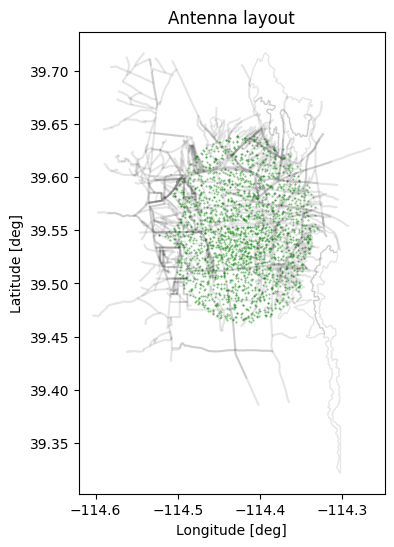

In [47]:
# Plot solutions
solution_file = "solution3.txt"
if not os.path.exists(solution_file):
    raise FileNotFoundError(f"Solution file {solution_file} not found")

with open(solution_file, 'r') as f:
    coords = []
    for line in f:
        if line.startswith("#"):
            continue
        x, y, z = line.strip().split(',')
        coords.append((float(x), float(y), float(z)))
coords = np.asarray(coords)
antennas = ac.EarthLocation.from_geocentric(
    coords[:, 0] * au.m,
    coords[:, 1] * au.m,
    coords[:, 2] * au.m
)

obstime = at.Time('2021-01-01T00:00:00', format='isot', scale='utc')
array_location = mean_itrs(antennas.get_itrs()).earth_location

antennas_enu = antennas.get_itrs(
    obstime=obstime, location=array_location
).transform_to(
    ENU(obstime=obstime, location=array_location)
).cartesian.xyz.to('m').value.T

# Plot along with regions
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
array_constraint = ArrayConstraint()
aoi_data = array_constraint.get_area_of_interest_regions()
constraint_data = array_constraint.get_constraint_regions()
# for sampler, buffer in aoi_data:
#     sampler.info()
#     sampler.plot_region(ax=ax, color='blue')
for sampler, buffer in constraint_data:
    sampler.plot_region(ax=ax, color='none')

# ax.scatter(antennas_enu[:, 0], antennas_enu[:, 1], s=1, c='green', alpha=0.5, marker='.')
ax.scatter(antennas.geodetic.lon.deg, antennas.geodetic.lat.deg, s=1, c='green', alpha=0.5, marker='.')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_title('Antenna layout')
plt.show()

Agree
Region Information:
  - File: /dsa/code/package/src/dsa2000_cal/assets/array_constraints/spring_valley_31b/Spring Valley Water Bodies.shp
  - Projection: +proj=longlat +datum=WGS84 +no_defs +type=crs
  - Number of polygons: 154
  - Total area: 0.00 square units
  - Total perimeter: 1.55 units
  - Centroid (longitude, latitude): (-114.4170, 39.5689)
  - Bounding box: [(-114.5111, 39.4999), (-114.3615, 39.6193)]
  - Columns: Index(['permanent_', 'fdate', 'resolution', 'gnis_id', 'gnis_name', 'areasqkm',
       'elevation', 'reachcode', 'ftype', 'fcode', 'visibility', 'SHAPE_Leng',
       'SHAPE_Area', 'ObjectID', 'geometry'],
      dtype='object')


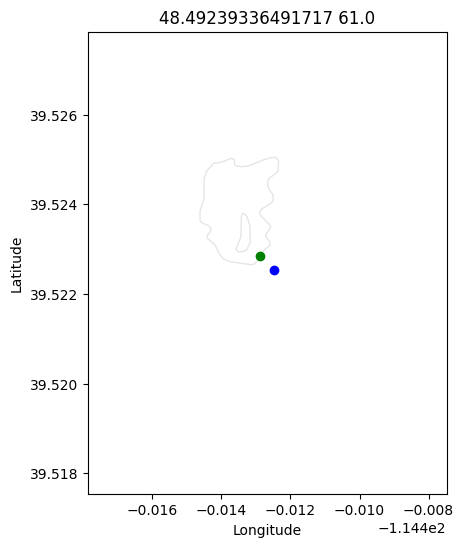

Agree
Region Information:
  - File: /dsa/code/package/src/dsa2000_cal/assets/array_constraints/spring_valley_31b/Spring Valley Water Bodies.shp
  - Projection: +proj=longlat +datum=WGS84 +no_defs +type=crs
  - Number of polygons: 154
  - Total area: 0.00 square units
  - Total perimeter: 1.55 units
  - Centroid (longitude, latitude): (-114.4170, 39.5689)
  - Bounding box: [(-114.5111, 39.4999), (-114.3615, 39.6193)]
  - Columns: Index(['permanent_', 'fdate', 'resolution', 'gnis_id', 'gnis_name', 'areasqkm',
       'elevation', 'reachcode', 'ftype', 'fcode', 'visibility', 'SHAPE_Leng',
       'SHAPE_Area', 'ObjectID', 'geometry'],
      dtype='object')


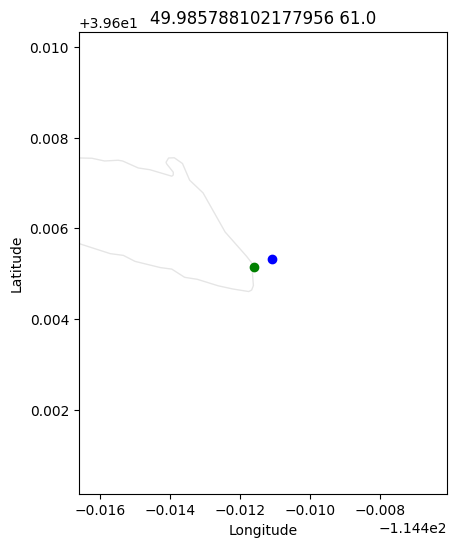

Agree
Region Information:
  - File: /dsa/code/package/src/dsa2000_cal/assets/array_constraints/spring_valley_31b/Spring Valley Water Bodies.shp
  - Projection: +proj=longlat +datum=WGS84 +no_defs +type=crs
  - Number of polygons: 154
  - Total area: 0.00 square units
  - Total perimeter: 1.55 units
  - Centroid (longitude, latitude): (-114.4170, 39.5689)
  - Bounding box: [(-114.5111, 39.4999), (-114.3615, 39.6193)]
  - Columns: Index(['permanent_', 'fdate', 'resolution', 'gnis_id', 'gnis_name', 'areasqkm',
       'elevation', 'reachcode', 'ftype', 'fcode', 'visibility', 'SHAPE_Leng',
       'SHAPE_Area', 'ObjectID', 'geometry'],
      dtype='object')


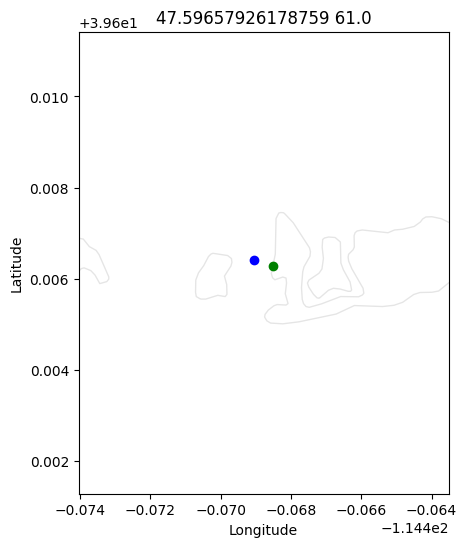

Agree
Region Information:
  - File: /dsa/code/package/src/dsa2000_cal/assets/array_constraints/spring_valley_31b/Fences.shp
  - Projection: +proj=longlat +datum=WGS84 +no_defs +type=crs
  - Number of polygons: 26
  - Total area: 0.00 square units
  - Total perimeter: 1.29 units
  - Centroid (longitude, latitude): (-114.4524, 39.5516)
  - Bounding box: [(-114.5470, 39.4106), (-114.3183, 39.6457)]
  - Columns: Index(['Name', 'FolderPath', 'SymbolID', 'AltMode', 'Base', 'Clamped',
       'Extruded', 'Snippet', 'PopupInfo', 'Shape_Leng', 'Notes', 'geometry'],
      dtype='object')


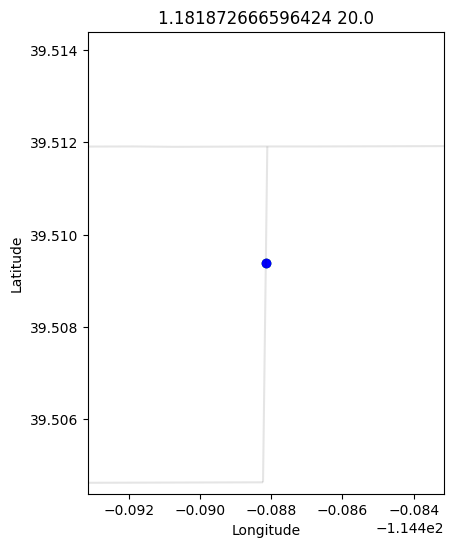

In [48]:
# Plot violations
for idx, point in enumerate(antennas):
    for sampler, buffer in constraint_data:
        (px, py), dist = sampler.closest_approach(point.geodetic.lon.deg, point.geodetic.lat.deg)
        earth_radius = np.linalg.norm(point.get_itrs().cartesian.xyz.to(au.m).value)
        dist = np.pi / 180 * dist * earth_radius

        if dist < buffer:
            print('Agree')
            sampler.info()
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            sampler.plot_region(ax=ax, color='none')
            ax.scatter(px, py, c='g')
            ax.scatter(point.geodetic.lon.deg, point.geodetic.lat.deg, c='b')
            bbox = min(point.geodetic.lon.deg, px), max(point.geodetic.lon.deg, px), min(point.geodetic.lat.deg,
                                                                                         py), max(
                point.geodetic.lat.deg, py)
            ax.set_xlim(bbox[0] - 0.005, bbox[1] + 0.005)
            ax.set_ylim(bbox[2] - 0.005, bbox[3] + 0.005)
            ax.set_title(f"{dist} {buffer}")
            plt.show()